In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import warnings
warnings.simplefilter("ignore")

from scipy.stats import kstest, spearmanr, mannwhitneyu, ttest_ind, levene, kruskal, pearsonr

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

c:\Users\pelik\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\pelik\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\pelik\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
data = pd.read_csv('ready_data.csv',index_col=0)

In [3]:
data.columns

Index(['price_per_square', 'squares', 'free', 'current_floor', 'max_floor',
       'latitude', 'longitude', 'Devyatkino', 'Grazhdanskii prospekt',
       'Akademicheskaya', 'Politekhnicheskaya', 'Ploshchad Muzhestva',
       'Lesnaia', 'Vyborgskaia', 'Ploshchad Lenina', 'Chernyshevskaia',
       'Ploshchad Vosstaniia', 'Vladimirskaia', 'Pushkinskaia',
       'Tekhnologicheskii institut-2', 'Baltiiskaia', 'Narvskaia',
       'Kirovskii zavod', 'Avtovo', 'Leninskii prospekt', 'Prospekt Veteranov',
       'Parnas', 'Prospekt Prosviashcheniia', 'Ozerki', 'Udelnaia',
       'Pionerskaia', 'Chernaia Rechka', 'Petropavlovskaia', 'Gorkovskaia',
       'Nevskii prospekt', 'Sennaia ploshchad', 'Tekhnologicheskii institut-1',
       'Frunzenskaia', 'Moskovskie vorota', 'Elektrosila', 'Park Pobedy',
       'Moskovskaia', 'Zvezdnaia', 'Kupchino', 'Spasskaia', 'Dostoevskaia',
       'Ligovskii prospekt', 'Ploshchad Aleksandra Nevskogo-2',
       'Novocherkasskaia', 'Ladozhskaia', 'Prospekt Bolshevik

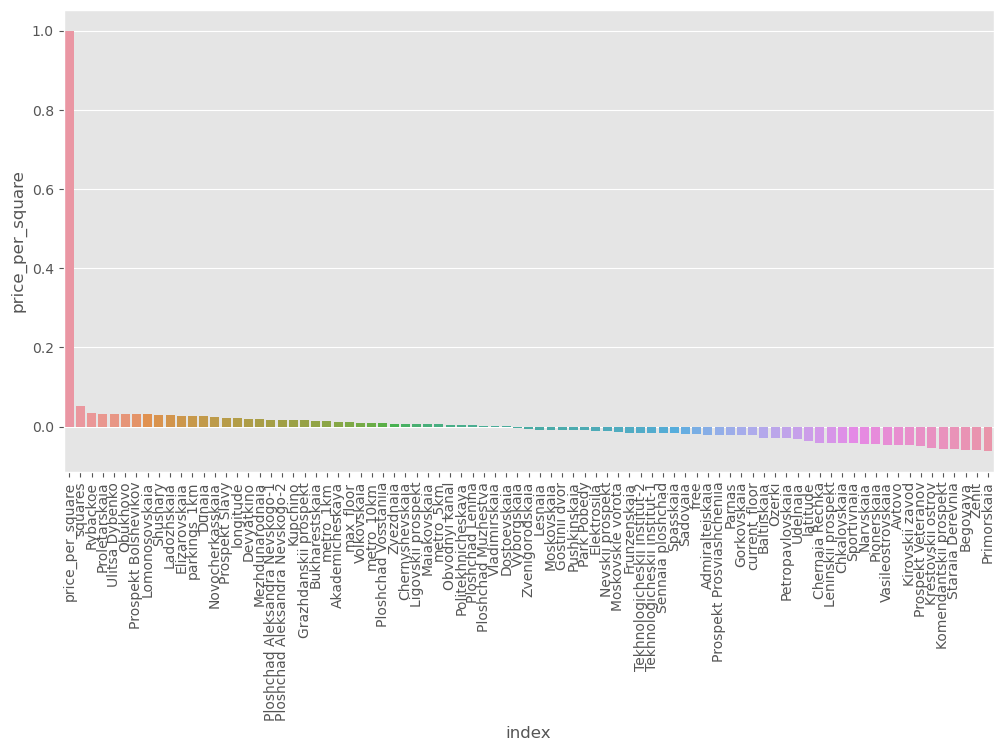

In [6]:
plt.figure(figsize=(12, 6))
sns.barplot(x='index',y='price_per_square',data = data.corr()['price_per_square'].reset_index().sort_values(by = 'price_per_square', ascending = False))
plt.xticks(rotation=90)
plt.show()

In [8]:
data = data[['price_per_square', 'squares', 'free', 'current_floor', 'max_floor',
       'latitude', 'longitude','parkings_1km','Nevskii prospekt','Devyatkino','Prospekt Veteranov','Primorskaia','Zenit','Komendantskii prospekt','Rybackoe']]

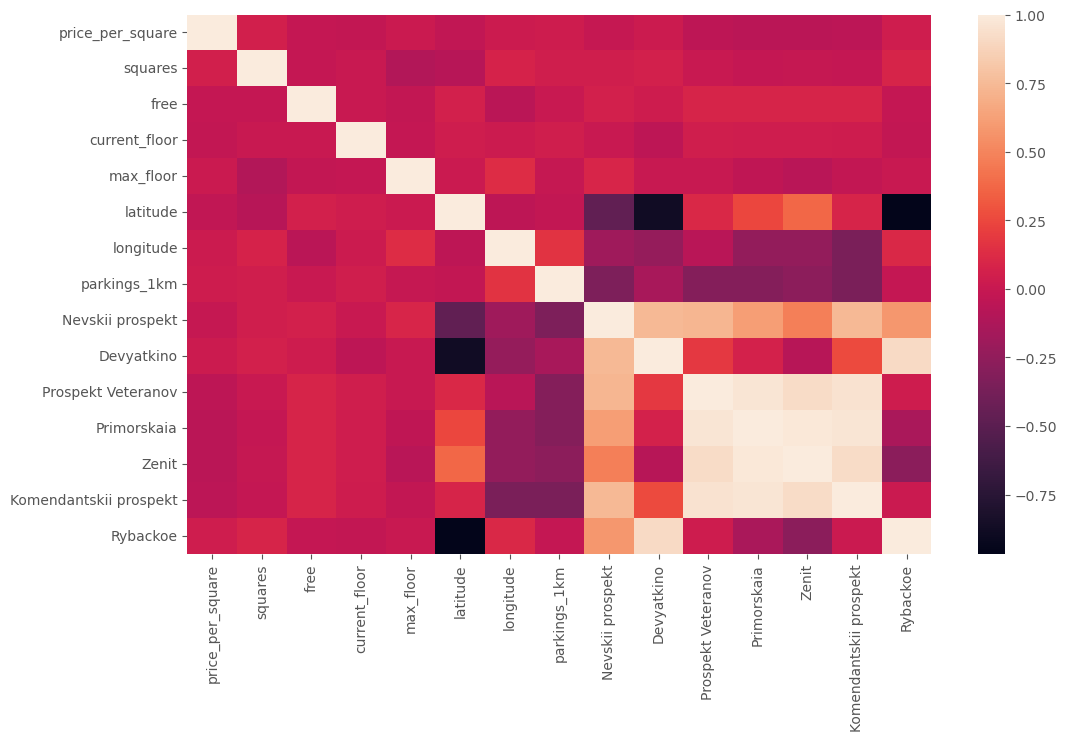

In [9]:
plt.figure(figsize=(12, 7))
sns.heatmap(data.corr(),annot = False, fmt='.1g')
plt.show()

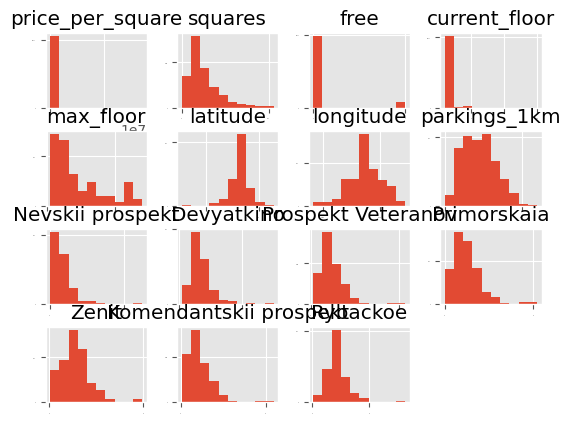

In [10]:
# histograms
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

# PRICE_PER_SQUARE

In [26]:
data = data[data['price_per_square']>= 30000.0]
data = data[data['price_per_square']<=450000.0]

Q1 = data['price_per_square'].quantile(0.05)
Q3 = data['price_per_square'].quantile(0.95)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['price_per_square'] >= lower_bound) & (data['price_per_square'] <= upper_bound)]

# SQUARES

In [6]:
data.squares.describe()

count    984.000000
mean     129.974339
std       95.664633
min        4.000000
25%       66.862500
50%       99.860000
75%      165.187500
max      530.000000
Name: squares, dtype: float64

In [27]:
data = data[data['squares']<=200]

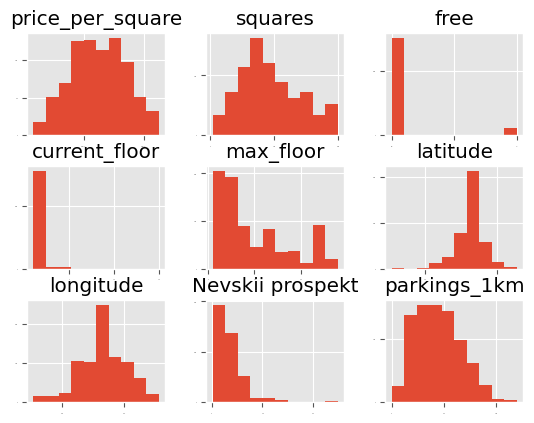

In [10]:
# histograms
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

In [8]:
data.squares.describe()

count    814.000000
mean      94.597727
std       46.787664
min        4.000000
25%       60.887500
50%       87.250000
75%      127.900000
max      200.000000
Name: squares, dtype: float64

# CURRENT_FLOOR и FREE

In [11]:
data = data[['price_per_square', 'squares', 'max_floor',
       'latitude', 'longitude','Nevskii prospekt','parkings_1km']]

CURRENT FLOOR не показала себя важным, как и free - наличие данных факторов было исключительно ввиду их изначального наличия. 
# оБЬЯСНИТЬ ПОЗЖЕ

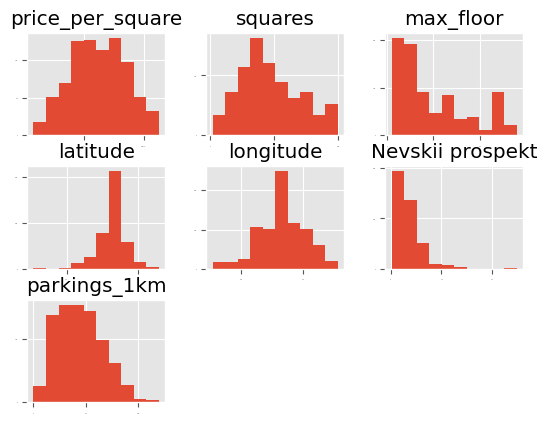

In [12]:
# histograms
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

убирать макс этаж - слишком вредно для данных - показывает относительную новизну здания и соотв сильно влияет, что мы заметили при прогонах модели.
Координаты тем более.

# Nevskiy

In [13]:
data['Nevskii prospekt'].describe()

count    814.000000
mean       8.537494
std        7.475832
min        0.500000
25%        3.432500
50%        6.940000
75%       11.270000
max       62.240000
Name: Nevskii prospekt, dtype: float64

In [14]:
data = data[data['Nevskii prospekt']<=30]

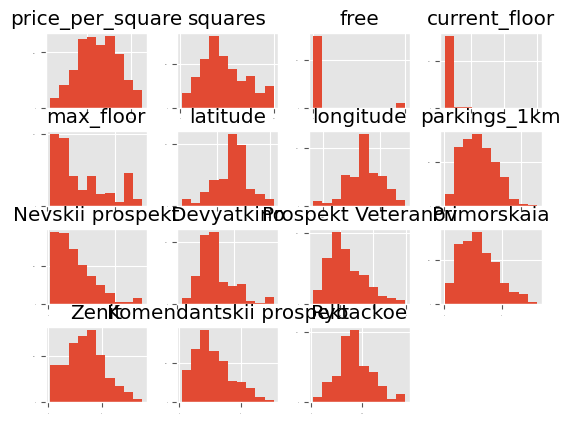

In [15]:
# histograms
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

# Прогоны

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error 
import statsmodels.api as sm

In [18]:
data.columns

Index(['price_per_square', 'squares', 'free', 'current_floor', 'max_floor',
       'latitude', 'longitude', 'parkings_1km', 'Nevskii prospekt',
       'Devyatkino', 'Prospekt Veteranov', 'Primorskaia', 'Zenit',
       'Komendantskii prospekt', 'Rybackoe'],
      dtype='object')

In [48]:
df_1 = data.copy()

# Определяем зависимые и не зависимые переменные
X = df_1[['squares', 'max_floor', 
                   'metro_5km']]
y = df_1['price_per_square']

# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем модель
model_1 = LinearRegression()
model_1.fit(X_scaled, y)

# Получаем коэфф. / веса параметров
coefficients = model_1.coef_
print(coefficients,'\n')

# Свободный коэф.
intercept = model_1.intercept_
print(intercept)

[-6473.33558242 29852.88390079 23644.74482998] 

248977.75307125307


In [49]:
X = sm.add_constant(np.array(X_scaled))
est = sm.OLS(y, X)
result = est.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       price_per_square   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     36.80
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           2.66e-22
Time:                        03:30:10   Log-Likelihood:                -10403.
No. Observations:                 814   AIC:                         2.081e+04
Df Residuals:                     810   BIC:                         2.083e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.49e+05   3017.929     82.500      0.0

In [50]:
predictions = result.predict(X)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(rmse)
print(mean_absolute_error(y, predictions))
print(mean_absolute_percentage_error(y, predictions))

85891.7637988
71291.85231961941
0.398237238734135


In [28]:
import pandas as pd
import statsmodels.api as sm

# Предположим, data - ваш DataFrame, и вы хотите анализировать 'price_per_square'
# Убедимся, что в 'data' нет пропусков в 'price_per_square'
data = data.dropna(subset=['price_per_square'])

# Выберем независимые переменные для анализа; предположим, это все кроме 'price_per_square'
X = data.drop('price_per_square', axis=1)
# Добавим константу для перехвата
X = sm.add_constant(X)
y = data['price_per_square']

# Строим модель
model = sm.OLS(y, X.astype(float)).fit()  # Используем astype(float), чтобы избежать проблем с типами данных

# Получаем сводку модели
print(model.summary())

# Сохраняем p-value
p_values = model.pvalues

# Выбираем только те параметры, где p-value < 0.05
significant_vars = p_values[p_values < 0.05].index.tolist()

print("Значимые переменные с p-value < 0.05:")
print(significant_vars)


                            OLS Regression Results                            
Dep. Variable:       price_per_square   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     5.740
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           2.77e-40
Time:                        03:26:16   Log-Likelihood:                -10252.
No. Observations:                 814   AIC:                         2.067e+04
Df Residuals:                     731   BIC:                         2.106e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [107]:
rk = pd.read_csv(r'C:\Users\pelik\python\diplomopis\spb_geo\boundary-polygon-land-lvl5.csv')

In [98]:
rk.columns

Index(['WKT\tNAME\tNAME_EN\tNAME_RU\tADMIN_LVL\tOSM_TYPE\tOSM_ID\tADMIN_L1D\tADMIN_L1\tADMIN_L2D\tADMIN_L2\tADMIN_L3D\tADMIN_L3\tADMIN_L4D\tADMIN_L4\tADMIN_L5D\tADMIN_L5\tADMIN_L6D\tADMIN_L6\tADMIN_L7D\tADMIN_L7\tADMIN_L8D\tADMIN_L8\tADMIN_L9D\tADMIN_L9\tADMIN_L10D\tADMIN_L10\toktmo\tokato'], dtype='object')

In [108]:
rk = rk.rename(columns={'WKT\tNAME\tNAME_EN\tNAME_RU\tADMIN_LVL\tOSM_TYPE\tOSM_ID\tADMIN_L1D\tADMIN_L1\tADMIN_L2D\tADMIN_L2\tADMIN_L3D\tADMIN_L3\tADMIN_L4D\tADMIN_L4\tADMIN_L5D\tADMIN_L5\tADMIN_L6D\tADMIN_L6\tADMIN_L7D\tADMIN_L7\tADMIN_L8D\tADMIN_L8\tADMIN_L9D\tADMIN_L9\tADMIN_L10D\tADMIN_L10\toktmo\tokato':'polygon'})

In [87]:
rk.iat[3,0]

'POLYGON ((30.3379519 59.9209349,30.3377953 59.9210607,30.3371941 59.9215543,30.3371123 59.9216252,30.3365553 59.9220907,30.3364728 59.9221597,30.3363696 59.9222493,30.3361621 59.9224251,30.336107 59.9224643,30.3352309 59.9233162,30.3357858 59.9235368,30.3304534 59.9260735,30.3300187 59.9262994,30.32703 59.9251507,30.3218708 59.9285986,30.318983 59.93053,30.3178175 59.9313099,30.3153107 59.9329953,30.3118605 59.9353013,30.3117762 59.9353581,30.311539 59.9355176,30.3114609 59.9355701,30.3114179 59.935599,30.3112298 59.9357255,30.3109312 59.9359263,30.3108416 59.9359866,30.3105593 59.9361765,30.3104029 59.9362817,30.3103119 59.9363429,30.3102313 59.9363971,30.3101295 59.9364655,30.3103024 59.9366458,30.3123914 59.9373876,30.3124162 59.9374581,30.3126331 59.9379477,30.3126379 59.9380088,30.3126288 59.9380613,30.3126137 59.9381018,30.3125887 59.9381449,30.3125619 59.9381783,30.3125203 59.9382183,30.3124762 59.9382558,30.3124315 59.9382896,30.309989 59.9398884,30.3090786 59.9405117,30.30827

In [109]:
districts = []

for i in range (18):
    string = rk.iat[i,0]

    # Разделение строки по табуляции и выбор английского значения
    english_value = string.split('\t')[2]

    # Удаление лишних пробелов и символов переноса строки
    english_value = english_value.strip()

    # Вывод результата
    districts.append(english_value)


In [84]:
districts.remove('Tsentralny District')

In [83]:
len(districts)

18

In [118]:
districts

['Pushkinsky District',
 'Kolpinsky District',
 'Primorsky District',
 'Tsentralny District',
 'Kalininsky District',
 'Krasnogvardeysky District',
 'Admiralteysky District',
 'Vyborgsky District',
 'Frunzensky District',
 'Nevsky District',
 'Petrogradsky District',
 'Vasileostrovsky District',
 'Krasnoselsky District',
 'Kirovsky District',
 'Moskovsky District',
 'Kronshtadtsky District',
 'Kurortny District',
 'Petrodvortsovy District']

In [119]:
data[districts] = 0

In [141]:
data.describe()

,price_per_square,squares,free,current_floor,max_floor,latitude,longitude,Devyatkino,Grazhdanskii prospekt,Akademicheskaya,...,Nevsky District,Petrogradsky District,Vasileostrovsky District,Krasnoselsky District,Kirovsky District,Moskovsky District,Kronshtadtsky District,Kurortny District,Petrodvortsovy District,Tsentralny District
count,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,...,814.0,814.0,814.0,814.0,814.0,814.0,814.0,814.0,814.0,814.0
mean,248977.753071,94.597727,0.072482,1.213759,9.656020,30.319170,59.931506,17.018686,14.599459,12.409939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,91614.854086,46.787664,0.259443,0.912403,8.001206,0.095973,0.075122,8.634087,8.424078,8.268664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,33750.000000,4.000000,0.000000,1.000000,1.000000,29.767554,59.707956,1.890000,1.160000,0.840000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,179469.500000,60.887500,0.000000,1.000000,3.000000,30.279046,59.885142,11.890000,9.440000,7.457500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,248954.000000,87.250000,0.000000,1.000000,7.000000,30.324950,59.932383,15.650000,12.875000,10.360000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,319169.500000,127.900000,0.000000,1.000000,14.000000,30.370313,59.985361,20.180000,17.310000,15.140000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,450000.000000,200.000000,1.000000,15.000000,28.000000,30.642972,60.110679,75.000000,72.300000,69.860000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.wkt import loads

In [155]:
rk['polygon'] = rk['polygon'].apply(loads)

TypeError: Expected bytes or string, got Polygon

In [169]:
def point_in_polygon(point):
    for polygon in range(len(rk['polygon'])):
        if rk['polygon'].iloc[polygon].contains(point):
            data[districts[polygon]][i] = 1
            print('aaa')
    return False

In [170]:
global i
for i in range(814):
        point_in_polygon(Point(data.iat[i,5],data.iat[i,6]))


aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa


In [173]:
data.columns

Index(['price_per_square', 'squares', 'free', 'current_floor', 'max_floor',
       'latitude', 'longitude', 'Devyatkino', 'Grazhdanskii prospekt',
       'Akademicheskaya',
       ...
       'Nevsky District', 'Petrogradsky District', 'Vasileostrovsky District',
       'Krasnoselsky District', 'Kirovsky District', 'Moskovsky District',
       'Kronshtadtsky District', 'Kurortny District',
       'Petrodvortsovy District', 'Tsentralny District'],
      dtype='object', length=101)

In [175]:
data = data.drop(columns='Tsentralny District')

In [180]:
data = data.drop(columns='Kronshtadtsky District')

In [181]:
data.corr()

,price_per_square,squares,max_floor,latitude,longitude,Nevskii prospekt,metro_1km,parkings_1km,Pushkinsky District,Kolpinsky District,...,Vyborgsky District,Frunzensky District,Nevsky District,Petrogradsky District,Vasileostrovsky District,Krasnoselsky District,Kirovsky District,Moskovsky District,Kurortny District,Petrodvortsovy District
price_per_square,1.000000,-0.088062,0.233729,-0.080354,0.047524,-0.196115,-0.012545,0.069567,0.031341,-0.074037,...,0.016720,-0.017130,-0.054189,0.041385,0.041860,0.043410,0.064598,0.001695,0.051764,0.071191
squares,-0.088062,1.000000,-0.006430,-0.074031,0.054823,0.025641,-0.087509,0.068831,0.028441,-0.064800,...,0.049349,-0.036413,0.009063,-0.029913,-0.007601,-0.000304,0.028204,-0.064918,-0.013349,0.009157
max_floor,0.233729,-0.006430,1.000000,0.000146,0.143383,0.130886,-0.246639,-0.038463,0.053694,-0.025944,...,0.022511,0.039402,0.006506,0.069034,0.079059,0.019843,-0.014403,-0.021650,-0.020421,0.001416
latitude,-0.080354,-0.074031,0.000146,1.000000,-0.007798,-0.322665,0.106432,-0.081196,0.026672,0.040923,...,0.009411,0.014040,-0.058351,-0.027569,0.000816,-0.028325,-0.005902,0.011062,-0.004482,-0.016876
longitude,0.047524,0.054823,0.143383,-0.007798,1.000000,-0.261285,-0.029254,0.142910,-0.073657,0.030683,...,0.026170,0.034445,0.000404,0.043890,-0.011160,0.005398,0.020322,0.011709,-0.003247,0.013380
Nevskii prospekt,-0.196115,0.025641,0.130886,-0.322665,-0.261285,1.000000,-0.416030,-0.346757,-0.002443,-0.020324,...,-0.038906,-0.050885,-0.015555,0.013924,-0.016133,-0.032960,-0.019302,-0.022629,-0.029139,-0.028300
metro_1km,-0.012545,-0.087509,-0.246639,0.106432,-0.029254,-0.416030,1.000000,0.114317,-0.027915,-0.008251,...,0.003509,0.050265,0.111502,-0.056548,0.014121,0.031054,-0.031474,0.042059,-0.022242,-0.019832
parkings_1km,0.069567,0.068831,-0.038463,-0.081196,0.142910,-0.346757,0.114317,1.000000,-0.001869,0.017828,...,0.015517,0.043309,0.026828,-0.011172,0.004951,0.012339,0.013719,0.073779,0.001380,-0.053671
Pushkinsky District,0.031341,0.028441,0.053694,0.026672,-0.073657,-0.002443,-0.027915,-0.001869,1.000000,-0.015881,...,-0.052304,-0.033356,-0.035052,-0.036681,-0.041732,-0.041732,-0.016988,-0.040762,-0.005980,-0.013406
Kolpinsky District,-0.074037,-0.064800,-0.025944,0.040923,0.030683,-0.020324,-0.008251,0.017828,-0.015881,1.000000,...,-0.028568,-0.018219,-0.019144,-0.020034,-0.022793,-0.022793,-0.009279,-0.022263,-0.003266,-0.007322


In [178]:
data = data[['price_per_square', 'squares', 'max_floor',
'latitude', 'longitude','Nevskii prospekt','metro_1km','parkings_1km','Pushkinsky District',
 'Kolpinsky District',
 'Primorsky District',
 'Kalininsky District',
 'Krasnogvardeysky District',
 'Admiralteysky District',
 'Vyborgsky District',
 'Frunzensky District',
 'Nevsky District',
 'Petrogradsky District',
 'Vasileostrovsky District',
 'Krasnoselsky District',
 'Kirovsky District',
 'Moskovsky District',
 'Kronshtadtsky District',
 'Kurortny District',
 'Petrodvortsovy District']]

In [183]:
df_1 = data.copy()

# Определяем зависимые и не зависимые переменные
X = df_1[['squares', 'max_floor',
'latitude', 'longitude','Nevskii prospekt','metro_1km','parkings_1km','Pushkinsky District',
 'Kolpinsky District',
 'Primorsky District',
 'Kalininsky District',
 'Krasnogvardeysky District',
 'Admiralteysky District',
 'Vyborgsky District',
 'Frunzensky District',
 'Nevsky District',
 'Petrogradsky District',
 'Vasileostrovsky District',
 'Krasnoselsky District',
 'Kirovsky District',
 'Moskovsky District',
 'Kurortny District',
 'Petrodvortsovy District']]
y = df_1['price_per_square']

# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем модель
model_1 = LinearRegression()
model_1.fit(X_scaled, y)

# Получаем коэфф. / веса параметров
coefficients = model_1.coef_
print(coefficients,'\n')

# Свободный коэф.
intercept = model_1.intercept_
print(intercept)

[ -8732.87935484  24743.21990731 -17224.40945432  -6610.01609897
 -31026.84393284  -5883.37860149  -1757.06918884   2441.32428868
  -5849.26049505   -251.706274      748.4590589    6151.03192515
   5368.8256473    2164.6158046   -2368.16559479  -4439.66386988
   2837.10592861   2611.41526576   3431.20787703   6307.91539235
   1381.00400275   4196.20409145   5694.75791624] 

248977.75307125336


In [184]:
X = sm.add_constant(np.array(X_scaled))
est = sm.OLS(y, X)
result = est.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       price_per_square   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     7.514
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           3.45e-22
Time:                        05:49:16   Log-Likelihood:                -10374.
No. Observations:                 814   AIC:                         2.080e+04
Df Residuals:                     790   BIC:                         2.091e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.49e+05   2950.692     84.379      0.0

In [185]:
predictions = result.predict(X)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(rmse)
print(mean_absolute_error(y, predictions))
print(mean_absolute_percentage_error(y, predictions))

82934.92556409117
67321.53570565204
0.3743332761261551
